# Prep

In [0]:
# ONLY FOR GOOGLE COLABORATORY, OTHERWISE RUN IT LOCALLY.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !pip install xlsxwriter

     |████████████████████████████████| 143kB 2.7MB/s 


In [0]:
# import required libraries
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import time
from openpyxl.reader.excel import load_workbook
%matplotlib inline

In [0]:
path = '/content/drive/My Drive/World Bank/Siap Tanggap/Data/'
path_output = '/content/drive/My Drive/World Bank/Siap Tanggap/Output/'
# convert downloaded files to csv (or excel but you gotta change the code) file first! 
# the downloaded file is a xml file, so pandas can't read it.

# filename
OT = 'OT.csv' # One-Time questionnaire
WK = 'Weekly.csv' # Weekly questionnaire
MT = 'Monthly.csv' # Monthly questionnaire
SHP = 'semarang_kelurahan.csv' # Indonesia shp file in 2016 per Desa/Kelurahan, from Edith
rw_list = "RW.xlsx" # from Jeremia

In [0]:
# formatting data
def formatdf(df):
  # stripping whitespaces
  df['Kecamatan'] = df['Kecamatan'].str.strip()
  df['Kelurahan'] = df['Kelurahan'].str.strip()
  # change RT values to integer, previously was float
  df.RT = df.RT.astype(int)
  # get rid of empty columns
  print("no of columns before dropping: {}".format(len(df.columns)))
  df.dropna(how='all', axis=1, inplace=True)
  print("no of columns after dropping: {}".format(len(df.columns)))

  return df

## GIS shapefile *keys

In [525]:
# open list of RW excel file
rwlist = pd.read_excel(path+rw_list)
rwlist['Kecamatan'] = rwlist['Kecamatan'].str.strip()
rwlist['Kelurahan'] = rwlist['Kelurahan'].str.strip()
kelurahan_list = rwlist[["Kecamatan","Kelurahan"]].drop_duplicates(subset=["Kecamatan","Kelurahan"])
kelurahan_list.reset_index(inplace=True)
kelurahan_list.drop(columns=["index"], inplace=True)
len(kelurahan_list)

177

In [0]:
# open shp table attribute file
shp = pd.read_csv(path+SHP)
shp["KECAMATAN"] = shp.KECAMATAN.str.title()
shp["DESA"] = shp.DESA.str.title()
shp = shp[['KECAMATAN', 'DESA', 'IDDESA']]

In [0]:
def replace_name(mode,kecamatan,name,kelurahan=None):
  """
  This function change the name of the shp table attribute so it can be merged.
  mode: 'kec' to change kecamatan name and 'kel' to change kelurahan name
  kecamatan: designated kecamatan to be replaced (according to shp file)
  kelurahan: designated kelurahan to be replaced (according to shp file), fill None if mode is 'kec'
  name: name to be replaced in kecamatan/kelurahan (string)
  """
  if mode == "kec":
    shp['kec_siap'][shp['kec_siap']==kecamatan] = name
  elif mode == "kel":
    shp['kel_siap'][(shp['kec_siap']==kecamatan)&(shp['kel_siap']==kelurahan)] = name
  else:
    print("Mode should be written as 'kec' or 'kel'")
  return shp

In [0]:
shp['kec_siap'] = shp['KECAMATAN']
shp['kel_siap'] = shp['DESA']
# Kecamatans to be renamed
change_kec = [["Gunung Pati","Gunungpati"],["Gajah Mungkur","Gajahmungkur"]]
for kec in range(0,len(change_kec)):
  shp = replace_name('kec',change_kec[kec][0],change_kec[kec][1])

# Kelurahans to be renamed
change_kel = [["Semarang Selatan",'Mugassari', 'Mugasari'],
              ["Pedurungan",'Plamongan Sari', 'Plamongansari'],
              ['Gayamsari','Sawahbesar','Sawah Besa'],
              ['Gayamsari','Tambakrejo','Tambakharjo'],
              ['Semarang Utara','Tanjungmas','Tanjung Mas'],
              ['Semarang Barat','Ngemplaksimongan','Ngemplak Simongan'],
              ['Semarang Barat','Bojongsalaman','Bojong Salaman'],
              ['Semarang Barat','Salamanmloyo','Salaman Mloyo'],
              ['Semarang Barat','Tambak Harjo','Tambakharjo'],
              ['Semarang Barat','Tawangsari','Tawang Sari'],
              ['Semarang Barat','Karang Ayu','Karanganyu'],
              ['Semarang Barat','Tawangmas','Tawang Mas'],
              ['Tugu','Jerakah','Jrakah'],
              ['Tugu','Randu Garut','Randugarut'],
              ['Mijen','Kedungpani','Kedungpane'],
              ['Gajahmungkur','Karang Rejo','Karangrejo'],
              ['Gunungpati','Sumurejo','Sumurrejo'],
              ['Gunungpati','Pungangan','Pongangan'],
              ['Gayamsari','Sawah Besa','Sawah Besar']]
for kel in range(0,len(change_kel)):
  shp = replace_name('kel',change_kel[kel][0],change_kel[kel][2],change_kel[kel][1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [0]:
# merge both dataframe
shp_code = pd.merge(kelurahan_list, shp,  how='outer', 
                    left_on=['Kecamatan','Kelurahan'], 
                    right_on=['kec_siap','kel_siap'])
shp_code.drop(columns=shp_code.columns[0:4],inplace=True)
print(len(shp_code))
shp_code.columns)

177
Index(['IDDESA', 'kec_siap', 'kel_siap'], dtype='object')


## One Time Data

In [0]:
ot = pd.read_csv(path+OT)
ot = formatdf(ot)
ot.head(2)

no of columns before dropping: 15
no of columns after dropping: 10


,Kecamatan,Kelurahan,RW,RT,Tandai lokasi RT Anda dalam peta,"Berapa jumlah penduduk/warga/orang di lingkungan Anda, termasuk penyewa/kos/kontrak?","Berapa jumlah KK/rumah tangga di RT Anda, termasuk penyewa/kos/kontrak?",Berapa jumlah penduduk/warga/orang dengan usia sama dengan atau lebih dari 60 tahun?,Berapa jumlah anak kecil dengan usia di bawah 5 tahun?,"Berapa jumlah orang dengan riwayat penyakit: penyakit paru-paru, asma, penyakit jantung, diabetes, penyakit ginjal, dan penyakit hati?"
0,Tembalang,Kramas,2,2,spatial,250,150,12,15,0
1,Tembalang,Sambiroto,1,1,spatial,192,67,21,14,9


In [0]:
# put IDDESA as a *key to shapefile
print("before merging: {}".format(ot.shape))
ot = pd.merge(ot, shp_code,  how='outer', left_on=['Kecamatan','Kelurahan'], right_on=['kec_siap','kel_siap'])
ot.drop(columns=ot.columns[-2:],inplace=True)
print("after merging: {}".format(ot.shape))

before merging: (4132, 10)
after merging: (4132, 11)


## Weekly data

In [0]:
wk = pd.read_csv(path+WK)
wk = formatdf(wk)
wk.head(1)

no of columns before dropping: 45
no of columns after dropping: 23


,Kecamatan,Kelurahan,RW,RT,"Berapa jumlah orang di RT Anda yang melaporkan gejala ringan dari infeksi COVID-19 atau gejala sejenis dalam seminggu terakhir? (Gejala ringan contohnya batuk, demam tinggi, atau kesulitan bernafas.)","Berapa jumlah orang di RT Anda yang melaporkan gejala berat dari infeksi COVID-19 atau gejala sejenis dalam seminggu terakhir? (Gejala berat contohnya kesulitan bernafas, sakit di dada, kehilangan daya rasa, bibir atau wajah membiru.)","Dari total jumlah yang melaporkan gejala, berapa banyak orang yang sudah ditest kesehatan (rapid test/PCR/Swab)?",Berapa jumlah orang yang sudah melakukan isolasi/karantina (mandiri/rumah sakit) karena menunjukkan gejala?,Apakah mayoritas rumah tangga/KK memiliki ruang yang cukup guna melakukan isolasi/karantina mandiri untuk anggota rumah tangga/KK dengan gejala seperti COVID-19?,"Sampai dengan minggu ini, berapa total kasus kematian yang diduga diakibatkan COVID-19, apabila ada?",Berapa jumlah orang yang pindah keluar dari RT Anda (termasuk orang-orang yang menyewa rumah/kos/pemudik) sampai dengan minggu ini sejak Maret?,Berapa jumlah orang yang datang ke RT Anda (termasuk orang-orang yang menyewa rumah/kos/pemudik) dalam seminggu ini?,Berapa jumlah pendatang di RT Anda dalam seminggu ini?,"Apakah para pendatang/pemudik tersebut sudah diminta untuk melakukan isolasi/karantina di rumah sendiri, atau di fasilitas khusus apabila tidak ada kewajiban untuk karantina?","Terhitung dari krisis COVID-19 di Bulan Maret, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) yang terkena pemutusan hubungan kerja (usaha formal) di RT Anda?","Terhitung dari krisis COVID-19 di Bulan Maret, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) yang kehilangan mata pencaharian (usaha informal) di RT Anda?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) yang terkena PHK (usaha formal) ?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) kehilangan mata pencaharian (usaha informal)?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK yang mengalami penurunan pendapatan secara signifikan meskipun pencari nafkah utamanya (laki-laki dan perempuan) tetap bekerja?","Dalam seminggu terakhir, berapa jumlah orang di RT Anda yang berkerja dari rumah dan menerima gajinya?","Terhitung dari krisis COVID-19 di Bulan Maret, berapa jumlah rumah tangga/KK yang mengalami penurunan pendapatan secara signifikan meskipun pencari nafkah utamanya (laki-laki dan perempuan) tetap bekerja?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK dalam lingkungan Anda yang menghadapi kekurangan pangan (kesulitan dalam memenuhi kebutuhan pangan) karena keterbatasan uang atau sumber daya lainnya?",Berapa banyak rumah tangga yang mengkonsumsi makanan lebih sedikit dibandingkan pada saat normal?
0,Tembalang,Tandang,9,10,0,0,0,0,50-75% dari total rumah tangga/KK,0,0,0,0,Diminta untuk melakukan karantina di rumah mas...,2,6,2,6,12,1,12,8,12


In [0]:
# put IDDESA as a *key to shapefile
print("before merging: {}".format(wk.shape))
wk = pd.merge(wk, shp_code,  how='inner', left_on=['Kecamatan','Kelurahan'], right_on=['kec_siap','kel_siap'])
wk.drop(columns=wk.columns[-2:],inplace=True)
print("after merging: {}".format(wk.shape))

before merging: (3769, 23)
after merging: (3769, 24)


## Monthly data

In [0]:
mt = pd.read_csv(path+MT)
mt = formatdf(mt)
mt.head(1)

no of columns before dropping: 145
no of columns after dropping: 67


,Kecamatan,Kelurahan,RW,RT,"Dalam sebulan terakhir, berapa jumlah rumah tangga/KK dalam lingkungan Anda yang menghadapi kekurangan pangan (kesulitan dalam memenuhi kebutuhan pangan) karena keterbatasan uang atau sumber daya lainnya?",Supermarket/pertokoan tidak memiliki stok,Pasar tradisional tidak beroperasi/tutup,Transportasi tidak ada/terbatas,Pembatasan untuk pergi ke luar,Kenaikan harga,Tidak ada akses untuk pembayaran cash dan tidak bisa membayar dengan kartu kredit,Tidak memiliki cukup uang untuk membayar,"Lainnya (sakit, lanjut usia, dll)",Keterbatasan fisik (Disabilitas),"Apakah terdapat program lumbung pangan, pangan mandiri, dll yang diinisiasi RT di daerah Anda?",Berapa jumlah rumah tangga/KK yang menerima bantuan sembako dari kontribusi RT?,Beras 1 kg,Minyak goreng 1 liter,Gula pasir 1 kg,Mie Instan 1 bungkus,Telur 1 kg,Daging sapi 1 kg,Daging ayam 1 kg,Gas elpiji 3 kg,"Dalam kurun waktu seminggu/sebulan terakhir, apakah terdapat anak kecil (0-5 tahun) di daerah anda yang kesulitan dalam memenuhi kebutuhan pangan dikarenakan kekurangan uang atau bahan makanan?","Kira-kira, berapa jumlah balita yang mengalami kesulitan memenuhi kebutuhan pangan?","Dalam kurun waktu seminggu/sebulan terakhir, apakah terdapat orang lanjut usia (60 tahun ke atas) di daerah anda yang kesulitan dalam memenuhi kebutuhan pangan dikarenakan kekurangan uang atau bahan makanan?","Kira-kira, berapa jumlah lansia yang mengalami kesulitan memenuhi kebutuhan pangan?","Secara keseluruhan, apakah RT memiliki akses yang cukup untuk air dan fasilitas sanitasi yang diperlukan untuk melakukan pembatasan jarak sosial (social distancing) dan jarak fisik (physical distancing)?",Jumlah rumah tangga/KK yang kekurangan akses ke air bersih untuk mematuhi himbauan mencuci tangan,Jumlah rumah tangga/KK yang tidak memiliki akses ke fasilitas sanitasi yang memadai (misalnya kamar kecil),"Jumlah rumah tangga/KK yang mengalami kesulitan menjaga praktik kebersihan yang diperlukan di luar fasilitas air dan sanitasi, misalnya, tidak ada sabun, desinfektan untuk membersihkan barang atau bahan antiseptik lainnya.",Pencurian,Pertengkaran fisik/verbal,Protes/demonstrasi,Penjarahan,Pada bulan lalu apakah pernah terjadi pengucilan terhadap orang yang diduga terinfeksi COVID-19 (ODP)?,Pada bulan lalu apakah pernah terjadi penolakan pemakaman korban meninggal dunia karena COVID-19?,Apakah terdapat Satpam/Keamanan di lingkungan Anda?,"Pada bulan lalu, apakah Anda pernah mendengar tentang kenaikan kasus kekerasan domestik atau kekerasan lainnya kepada wanita (KDRT - ”kekekerasan dalam rumah tangga”)?",Apakah ada titik pantau akses keluar-masuk di RT Anda?,Himbauan cuci tangan,Himbauan penggunaan masker di luar rumah,Himbauan pola hidup bersih serhat (PHBS),Himbauan untuk tinggal di rumah,"Himbauan menghindari kegiatan berkumpul (termasuk kegiatan keagamaan, resepsi nikah, rapat-rapat, kegiatan sosial, pemakaman, dll)",Himbauan perantau untuk tidak pulang,Himbauan tidak jabat tangan/cium tangan,Himbauan melakukan tindakan pembatasan sosial (social distancing) dan pembatasan fisik (physical distancing),"Himbauan untuk tidak menyentuh wajah, tangan, mulut, hidung, mata, telinga, dan lainnya",Memantau pemudik/pendatang,Mendata warga dengan gejala COVID-19,Melakukan penyemprotan disinfektan,Menutup/membatasi akses jalan RT,Menyediakan tempat/sarana cuci tangan,Memperingatkan warga yang tidak mengenakan masker,Membubarkan warga yang berkumpul lebih dari 5 orang,Melakukan pengecekan suhu badan bagi orang yang masuk wilayah RT,Membuat ruangan isolasi/karantina di RT,BPNT/Rastra (Bantuan sembako dari pemerintah pusat via voucher KKS),PKH (Program Keluarga Harapan),PKT (Padat Karya Tunai),BLT (Bantuan Langsung Tunai),Bantuan pangan/Bantuan Sosial/Sembako,Kartu Pra-kerja,"Bantuan Sosial/Sembako Non-Pemerintah (CSR, Swasta, Yayasan, Ormas, dan lainnya)","Suplemen kesehatan, sanitizer atau masker"
0,Gunungpati,Mangunsari,4,7,0,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Ya,0,1000

In [0]:
# put IDDESA as a *key to shapefile
print("before merging: {}".format(mt.shape))
mt = pd.merge(mt, shp_code,  how='inner', left_on=['Kecamatan','Kelurahan'], right_on=['kec_siap','kel_siap'])
mt.drop(columns=mt.columns[-2:],inplace=True)
print("after merging: {}".format(mt.shape))

before merging: (3533, 67)
after merging: (3533, 68)


# Recapitulation

In [0]:
# Count the number of RW per Kelurahans
rwlist = pd.merge(rwlist, shp_code,  how='outer', left_on=['Kecamatan','Kelurahan'], 
                  right_on=['kec_siap','kel_siap'])
rwlist.drop(columns=rwlist.columns[-2:],inplace=True)
allRWperKEL = rwlist.groupby(['IDDESA','Kecamatan','Kelurahan'])[['RW']].count()
allRWperKEL.reset_index(inplace=True)

In [0]:
def RTcounter(df):
  """
  Count the frequency of RT's submission
  df: downloaded data
  """
  data = {"IDDESA":[],"Kecamatan":[],"Kelurahan":[],"RW":[],"RT":[],"Frequency":[]}
  for id in df["IDDESA"].unique():
    for rw in df[df["IDDESA"]==id]["RW"].unique():
      for _, row in df[(df["IDDESA"]==id)&(df["RW"]==rw)]["RT"].value_counts().reset_index().iterrows():
        data["IDDESA"].append(id)
        data["Kecamatan"].append(df[df["IDDESA"]==id]["Kecamatan"].iloc[0])
        data["Kelurahan"].append(df[df["IDDESA"]==id]["Kelurahan"].iloc[0])
        data["RW"].append(rw)
        data["RT"].append(row["index"])
        data["Frequency"].append(row["RT"])
  return data

In [0]:
def RTperRW(df):
  """
  Count the number of RTs in each RWs (duplicate is not included)
  df: dataframe after RTcounter()
  """
  rt = pd.DataFrame(df.drop("Frequency",axis=1).groupby(['IDDESA','Kecamatan','Kelurahan','RW'])[['RW']].count())
  rt.rename(columns={"RW":"RT counts"}, inplace=True)
  rt = rt.reset_index()
  return rt

def RWperKEL(df):
  """
  Count the number of RWs in each Kelurahans
  df: dataframe after RTperRW()
  """
  d = df.copy()
  d["RW counts"] = 1
  rw = d.groupby(['IDDESA','Kecamatan','Kelurahan'])[['RW counts','RT counts']].apply(sum)
  rw = rw.reset_index()
  rw = pd.merge(rw, allRWperKEL,  how='outer', left_on=['IDDESA','Kecamatan','Kelurahan'],
                right_on=['IDDESA','Kecamatan','Kelurahan']).fillna(0)
  rw.rename(columns={"RW":"Actual RW"},inplace=True)
  rw[["RW counts","RT counts"]] = rw[["RW counts","RT counts"]].astype(int)
  rw["RW (%)"] =  100-((rw["Actual RW"]-rw["RW counts"])/rw["Actual RW"]*100)
  rw["RW (%)"] = rw["RW (%)"].round(2)
  return rw

In [0]:
def saver(df,fname,sname,mode):
  """
  General function to save file as an excel file with multiple sheets
  df: dataframe
  fname: excel filename
  sname: sheetname to be saved as
  mode: 'w' for write (if no previous docs exist), 'a' for append
  """
  TodaysDate = time.strftime("%d-%m-%Y")
  excelfilename = fname + TodaysDate +".xlsx"
  filename = path_output+excelfilename
  if mode=="a":
    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a')
    writer.book = load_workbook(filename)
    df.to_excel(writer,sheet_name=sname)
    writer.save()
    writer.close()
  elif mode=="w":
    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='w')
    df.to_excel(writer,sheet_name=sname)
    writer.save()
    writer.close()  
  else:
    print("Mode must be chosen between 'w' or 'a'")

In [0]:
# check RW with zero participation
def zeroRW(df,sname,mode):
  """
  Collects a list of RW with zero participation.
  df: dataframe after RTperRW()
  sname: sheetname to be saved as
  mode: 'w' for write (if no docs exist), 'a' for append
  """
  zeroRW = pd.merge(df, rwlist,  how='outer', 
                    left_on=['IDDESA','Kecamatan','Kelurahan','RW'], 
                    right_on=['IDDESA','Kecamatan','Kelurahan','RW']).fillna(0)
  zeroRW["RT counts"] = zeroRW["RT counts"].astype(int)
  zeroRW = zeroRW[zeroRW["RT counts"]==0]
  saver(zeroRW,"Zero RW ",sname,mode)
  return zeroRW

In [0]:
# save duplicate entries
def save_duplicates(freq,df,sname,mode):
  """
  freq: dataframe of data entry recapitulation
  df: original dataframe of ot/wk/mt (the downloaded data)
  sname: filename to be saved as
  mode: 'w' for write (if document haven't created), 'a' for append
  """
  d = pd.DataFrame()
  for _, row in freq[freq["Frequency"]>1].iterrows():
    a = df[(df["Kecamatan"]==row["Kecamatan"])&(df["Kelurahan"]==row["Kelurahan"])&
          (df["RW"]==row["RW"])&(df["RT"]==row["RT"])]
    d = d.append(a)
  saver(d,"Duplicates ",sname,mode)  
  return d

## RT's Participation

### One Time Data

In [565]:
no_rt_ot = pd.DataFrame(RTcounter(ot))
no_rt_ot.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT,Frequency
0,3374070003,Tembalang,Kramas,2,2,2
1,3374070003,Tembalang,Kramas,6,3,2


In [610]:
# check duplicate entries
print("no of duplicate entries: {}".format(len(no_rt_ot[no_rt_ot["Frequency"]>1])))
save_duplicates(no_rt_ot,ot,"OT","w")

no of duplicate entries: 110


,Kecamatan,Kelurahan,RW,RT,Tandai lokasi RT Anda dalam peta,"Berapa jumlah penduduk/warga/orang di lingkungan Anda, termasuk penyewa/kos/kontrak?","Berapa jumlah KK/rumah tangga di RT Anda, termasuk penyewa/kos/kontrak?",Berapa jumlah penduduk/warga/orang dengan usia sama dengan atau lebih dari 60 tahun?,Berapa jumlah anak kecil dengan usia di bawah 5 tahun?,"Berapa jumlah orang dengan riwayat penyakit: penyakit paru-paru, asma, penyakit jantung, diabetes, penyakit ginjal, dan penyakit hati?",IDDESA
0,Tembalang,Kramas,2,2,spatial,250,150,12,15,0,3374070003
5,Tembalang,Kramas,2,2,spatial,92,29,24,5,0,3374070003
1,Tembalang,Kramas,6,3,spatial,96,27,3,8,3,3374070003
6,Tembalang,Kramas,6,3,spatial,168,48,9,20,0,3374070003
2,Tembalang,Kramas,5,4,spatial,8,3,0,10,0,3374070003
...,...,...,...,...,...,...,...,...,...,...,...
2447,Semarang Barat,Tawang Mas,4,3,spatial,68,36,8,11,10,3374140016
2448,Semarang Barat,Tawang Mas,4,3,spatial,68,36,10,10,10,3374140016
4040,Semarang Utara,Dadapsari,5,3,spatial,1,55,17,14,3,3374120007
4042,Semarang Utara,Dadapsari,5,3,spatial,1,55,17,14,3,3374120007


In [573]:
# Counts the number of RT submission in each RWs
rt_ot = RTperRW(no_rt_ot)
rt_ot.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT counts
0,3374010001,Mijen,Cangkiran,2,2
1,3374010001,Mijen,Cangkiran,3,2


### Weekly Data

In [542]:
no_rt_wk = pd.DataFrame(RTcounter(wk))
no_rt_wk.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT,Frequency
0,3374070010,Tembalang,Tandang,9,10,2
1,3374070010,Tembalang,Tandang,9,4,1


In [615]:
# check duplicate entries
print("no of duplicate entries: {}".format(len(no_rt_wk[no_rt_wk["Frequency"]>1])))
save_duplicates(no_rt_wk,wk,"Weekly","a")

no of duplicate entries: 92


,Kecamatan,Kelurahan,RW,RT,"Berapa jumlah orang di RT Anda yang melaporkan gejala ringan dari infeksi COVID-19 atau gejala sejenis dalam seminggu terakhir? (Gejala ringan contohnya batuk, demam tinggi, atau kesulitan bernafas.)","Berapa jumlah orang di RT Anda yang melaporkan gejala berat dari infeksi COVID-19 atau gejala sejenis dalam seminggu terakhir? (Gejala berat contohnya kesulitan bernafas, sakit di dada, kehilangan daya rasa, bibir atau wajah membiru.)","Dari total jumlah yang melaporkan gejala, berapa banyak orang yang sudah ditest kesehatan (rapid test/PCR/Swab)?",Berapa jumlah orang yang sudah melakukan isolasi/karantina (mandiri/rumah sakit) karena menunjukkan gejala?,Apakah mayoritas rumah tangga/KK memiliki ruang yang cukup guna melakukan isolasi/karantina mandiri untuk anggota rumah tangga/KK dengan gejala seperti COVID-19?,"Sampai dengan minggu ini, berapa total kasus kematian yang diduga diakibatkan COVID-19, apabila ada?",Berapa jumlah orang yang pindah keluar dari RT Anda (termasuk orang-orang yang menyewa rumah/kos/pemudik) sampai dengan minggu ini sejak Maret?,Berapa jumlah orang yang datang ke RT Anda (termasuk orang-orang yang menyewa rumah/kos/pemudik) dalam seminggu ini?,Berapa jumlah pendatang di RT Anda dalam seminggu ini?,"Apakah para pendatang/pemudik tersebut sudah diminta untuk melakukan isolasi/karantina di rumah sendiri, atau di fasilitas khusus apabila tidak ada kewajiban untuk karantina?","Terhitung dari krisis COVID-19 di Bulan Maret, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) yang terkena pemutusan hubungan kerja (usaha formal) di RT Anda?","Terhitung dari krisis COVID-19 di Bulan Maret, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) yang kehilangan mata pencaharian (usaha informal) di RT Anda?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) yang terkena PHK (usaha formal) ?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK dengan pencari nafkah utama (laki-laki dan perempuan) kehilangan mata pencaharian (usaha informal)?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK yang mengalami penurunan pendapatan secara signifikan meskipun pencari nafkah utamanya (laki-laki dan perempuan) tetap bekerja?","Dalam seminggu terakhir, berapa jumlah orang di RT Anda yang berkerja dari rumah dan menerima gajinya?","Terhitung dari krisis COVID-19 di Bulan Maret, berapa jumlah rumah tangga/KK yang mengalami penurunan pendapatan secara signifikan meskipun pencari nafkah utamanya (laki-laki dan perempuan) tetap bekerja?","Dalam seminggu terakhir, berapa jumlah rumah tangga/KK dalam lingkungan Anda yang menghadapi kekurangan pangan (kesulitan dalam memenuhi kebutuhan pangan) karena keterbatasan uang atau sumber daya lainnya?",Berapa banyak rumah tangga yang mengkonsumsi makanan lebih sedikit dibandingkan pada saat normal?,IDDESA
0,Tembalang,Tandang,9,10,0,0,0,0,50-75% dari total rumah tangga/KK,0,0,0,0,Diminta untuk melakukan karantina di rumah mas...,2,6,2,6,12,1,12,8,12,3374070010
18,Tembalang,Tandang,9,10,0,0,1,0,0-25% dari total rumah tangga/KK,0,0,0,0,Tidak ada persyaratan untuk melakukan karantina,1,1,0,0,7,0,7,7,7,3374070010
1,Tembalang,Tandang,10,2,0,0,0,0,50-75% dari total rumah tangga/KK,0,0,0,0,Diminta untuk melakukan karantina di rumah mas...,6,10,5,20,35,0,35,35,35,3374070010
23,Tembalang,Tandang,10,2,0,0,0,0,25-50% dari total rumah tangga/KK,0,0,0,0,Diminta untuk melakukan karantina di rumah mas...,45,45,3,45,14,5,25,5,11,3374070010
37,Tembalang,Sambiroto,7,4,0,0,0,0,25-50% dari total rumah tangga/KK,0,1,1,0,Diminta untuk melakukan karantina di rumah mas...,25,40,15,10,15,0,15,40,45,3374070008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,Semarang Utara,Dadapsari,5,3,0,0,0,0,0-25% dari total rumah tangga/KK,0,0,0,0,Tidak ada persyaratan untuk melakukan karantina,0,10,0,0,0,0,10,7,11,33

In [578]:
# Counts the number of RT submission in each RWs
rt_wk = RTperRW(no_rt_wk)
rt_wk.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT counts
0,3374010001,Mijen,Cangkiran,1,2
1,3374010001,Mijen,Cangkiran,2,2


### Monthly Data

In [544]:
no_rt_mt = pd.DataFrame(RTcounter(mt))
no_rt_mt.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT,Frequency
0,3374020005,Gunungpati,Mangunsari,4,7,1
1,3374020005,Gunungpati,Mangunsari,4,6,1


In [616]:
# check duplicate entries
print("no of duplicate entries: {}".format(len(no_rt_mt[no_rt_mt["Frequency"]>1])))
save_duplicates(no_rt_mt,mt,"Monthly","a")

no of duplicate entries: 72


,Kecamatan,Kelurahan,RW,RT,"Dalam sebulan terakhir, berapa jumlah rumah tangga/KK dalam lingkungan Anda yang menghadapi kekurangan pangan (kesulitan dalam memenuhi kebutuhan pangan) karena keterbatasan uang atau sumber daya lainnya?",Supermarket/pertokoan tidak memiliki stok,Pasar tradisional tidak beroperasi/tutup,Transportasi tidak ada/terbatas,Pembatasan untuk pergi ke luar,Kenaikan harga,Tidak ada akses untuk pembayaran cash dan tidak bisa membayar dengan kartu kredit,Tidak memiliki cukup uang untuk membayar,"Lainnya (sakit, lanjut usia, dll)",Keterbatasan fisik (Disabilitas),"Apakah terdapat program lumbung pangan, pangan mandiri, dll yang diinisiasi RT di daerah Anda?",Berapa jumlah rumah tangga/KK yang menerima bantuan sembako dari kontribusi RT?,Beras 1 kg,Minyak goreng 1 liter,Gula pasir 1 kg,Mie Instan 1 bungkus,Telur 1 kg,Daging sapi 1 kg,Daging ayam 1 kg,Gas elpiji 3 kg,"Dalam kurun waktu seminggu/sebulan terakhir, apakah terdapat anak kecil (0-5 tahun) di daerah anda yang kesulitan dalam memenuhi kebutuhan pangan dikarenakan kekurangan uang atau bahan makanan?","Kira-kira, berapa jumlah balita yang mengalami kesulitan memenuhi kebutuhan pangan?","Dalam kurun waktu seminggu/sebulan terakhir, apakah terdapat orang lanjut usia (60 tahun ke atas) di daerah anda yang kesulitan dalam memenuhi kebutuhan pangan dikarenakan kekurangan uang atau bahan makanan?","Kira-kira, berapa jumlah lansia yang mengalami kesulitan memenuhi kebutuhan pangan?","Secara keseluruhan, apakah RT memiliki akses yang cukup untuk air dan fasilitas sanitasi yang diperlukan untuk melakukan pembatasan jarak sosial (social distancing) dan jarak fisik (physical distancing)?",Jumlah rumah tangga/KK yang kekurangan akses ke air bersih untuk mematuhi himbauan mencuci tangan,Jumlah rumah tangga/KK yang tidak memiliki akses ke fasilitas sanitasi yang memadai (misalnya kamar kecil),"Jumlah rumah tangga/KK yang mengalami kesulitan menjaga praktik kebersihan yang diperlukan di luar fasilitas air dan sanitasi, misalnya, tidak ada sabun, desinfektan untuk membersihkan barang atau bahan antiseptik lainnya.",Pencurian,Pertengkaran fisik/verbal,Protes/demonstrasi,Penjarahan,Pada bulan lalu apakah pernah terjadi pengucilan terhadap orang yang diduga terinfeksi COVID-19 (ODP)?,Pada bulan lalu apakah pernah terjadi penolakan pemakaman korban meninggal dunia karena COVID-19?,Apakah terdapat Satpam/Keamanan di lingkungan Anda?,"Pada bulan lalu, apakah Anda pernah mendengar tentang kenaikan kasus kekerasan domestik atau kekerasan lainnya kepada wanita (KDRT - ”kekekerasan dalam rumah tangga”)?",Apakah ada titik pantau akses keluar-masuk di RT Anda?,Himbauan cuci tangan,Himbauan penggunaan masker di luar rumah,Himbauan pola hidup bersih serhat (PHBS),Himbauan untuk tinggal di rumah,"Himbauan menghindari kegiatan berkumpul (termasuk kegiatan keagamaan, resepsi nikah, rapat-rapat, kegiatan sosial, pemakaman, dll)",Himbauan perantau untuk tidak pulang,Himbauan tidak jabat tangan/cium tangan,Himbauan melakukan tindakan pembatasan sosial (social distancing) dan pembatasan fisik (physical distancing),"Himbauan untuk tidak menyentuh wajah, tangan, mulut, hidung, mata, telinga, dan lainnya",Memantau pemudik/pendatang,Mendata warga dengan gejala COVID-19,Melakukan penyemprotan disinfektan,Menutup/membatasi akses jalan RT,Menyediakan tempat/sarana cuci tangan,Memperingatkan warga yang tidak mengenakan masker,Membubarkan warga yang berkumpul lebih dari 5 orang,Melakukan pengecekan suhu badan bagi orang yang masuk wilayah RT,Membuat ruangan isolasi/karantina di RT,BPNT/Rastra (Bantuan sembako dari pemerintah pusat via voucher KKS),PKH (Program Keluarga Harapan),PKT (Padat Karya Tunai),BLT (Bantuan Langsung Tunai),Bantuan pangan/Bantuan Sosial/Sembako,Kartu Pra-kerja,"Bantuan Sosial/Sembako Non-Pemerintah (CSR, Swasta, Yayasan, Ormas, dan lainnya)","Suplemen kesehatan, sanitizer atau masker",IDDESA
17,Semarang Tengah,Pandansari,2,2,48,Ya,Ya,Ya,Ya,Tidak,Ya,Ya,Ya,Tidak,Tidak,44,12500,1

In [579]:
rt_mt = RTperRW(no_rt_mt)
rt_mt.head(3)

,IDDESA,Kecamatan,Kelurahan,RW,RT counts
0,3374010001,Mijen,Cangkiran,2,2
1,3374010001,Mijen,Cangkiran,3,2
2,3374010001,Mijen,Cangkiran,4,1


## RW's participation

### One Time Data

In [575]:
zeroRW_ot = zeroRW(rt_ot,"OT","w")
print(len(zeroRW_ot))
zeroRW_ot.head(2)

394


,IDDESA,Kecamatan,Kelurahan,RW,RT counts
1106,3374140008,Semarang Barat,Gisikdrono,1,0
1107,3374140008,Semarang Barat,Gisikdrono,12,0


In [576]:
rw_ot = RWperKEL(rt_ot)
rw_ot.head(2)

,IDDESA,Kecamatan,Kelurahan,RW counts,RT counts,Actual RW,RW (%)
0,3374010001,Mijen,Cangkiran,7,17,8,87.5
1,3374010002,Mijen,Bubakan,2,4,5,40.0


### Weekly Data

In [580]:
zeroRW_wk = zeroRW(rt_wk,"Weekly","a")
print(len(zeroRW_wk))
zeroRW_wk.head(2)

447


,IDDESA,Kecamatan,Kelurahan,RW,RT counts
1053,3374140005,Semarang Barat,Bojong Salaman,6,0
1054,3374140004,Semarang Barat,Bongsari,7,0


In [581]:
rw_wk = RWperKEL(rt_wk)
rw_wk.head(2)

,IDDESA,Kecamatan,Kelurahan,RW counts,RT counts,Actual RW,RW (%)
0,3374010001,Mijen,Cangkiran,8,21,8,100.0
1,3374010002,Mijen,Bubakan,2,4,5,40.0


### Monthly Data

In [583]:
zeroRW_mt = zeroRW(rt_mt,"Weekly","a")
print(len(zeroRW_mt))
zeroRW_mt.head(2)

489


,IDDESA,Kecamatan,Kelurahan,RW,RT counts
1011,3374140005,Semarang Barat,Bojong Salaman,6,0
1012,3374140004,Semarang Barat,Bongsari,7,0


In [584]:
rw_mt = RWperKEL(rt_mt)
rw_mt.head(2)

,IDDESA,Kecamatan,Kelurahan,RW counts,RT counts,Actual RW,RW (%)
0,3374010001,Mijen,Cangkiran,7,15,8,87.5
1,3374010002,Mijen,Bubakan,1,3,5,20.0


## Kelurahan's participation

In [0]:
#check using is in
print("No of entries: {} RWs".format(len(rwlist[rwlist['unique_ID'].isin(df['unique_ID'])==True])))

No of entries: 1102 RWs


In [586]:
rt_ot

,IDDESA,Kecamatan,Kelurahan,RW,RT counts
0,3374010001,Mijen,Cangkiran,2,2
1,3374010001,Mijen,Cangkiran,3,2
2,3374010001,Mijen,Cangkiran,4,1
3,3374010001,Mijen,Cangkiran,5,3
4,3374010001,Mijen,Cangkiran,6,1
...,...,...,...,...,...
1101,3374160010,Ngaliyan,Wonosari,12,1
1102,3374160010,Ngaliyan,Wonosari,13,1
1103,3374160010,Ngaliyan,Wonosari,14,1
1104,3374160010,Ngaliyan,Wonosari,15,4


In [0]:
def RTnRWrecap(df,sname,mode):
  """
  
  """
  x = pd.merge(df, rwlist,  how='outer', left_on=['IDDESA','Kecamatan','Kelurahan',"RW"],
              right_on=['IDDESA','Kecamatan','Kelurahan',"RW"]).fillna(0)         
  x["RT counts"] = x["RT counts"].astype(int)
  x = pd.DataFrame(data=list(x["RT counts"].value_counts()),
                  index=[x["RT counts"].value_counts().index],columns=["No of RW"])
  x = x.reset_index()
  x.columns = ["No of participating RTs","No of RW"]
  saver(x,"RT value counts per RW ",sname,mode)
  x.sort_values("No of participating RTs").plot.bar(x='No of participating RTs', y='No of RW')
  pl.xticks(rotation=0)

In [0]:
# merge[merge['jumlah']==0].to_csv(path_output+"Zero participation (RW).csv")

In [0]:
jumlahRW = pd.DataFrame(data=list(rw_ot["RW counts"].value_counts()),
                        index=[rw_ot["RW counts"].value_counts().index],columns=["jumlah RW"])
jumlahRW = jumlahRW.reset_index()
jumlahRW.columns = ["No of participating RTs","No of RW"]

In [0]:
jumlahRW.sort_values("No of participating RTs")

,No of participating RTs,No of RW
0,0,398
1,1,282
2,2,186
3,3,158
4,4,131
5,5,100
6,6,98
7,7,70
8,8,28
9,9,22


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

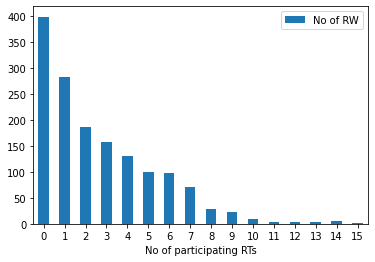

In [0]:
jumlahRW.sort_values("No of participating RTs").plot.bar(x='No of participating RTs', y='No of RW')
pl.xticks(rotation=0)

In [0]:
jumlahRW["percentage %"] = jumlahRW["No of RW"]/(1500)*100
jumlahRW

,No of participating RTs,No of RW,percentage %
0,0,398,26.533333
1,1,282,18.800000
2,2,186,12.400000
3,3,158,10.533333
4,4,131,8.733333
5,5,100,6.666667
6,6,98,6.533333
7,7,70,4.666667
8,8,28,1.866667
9,9,22,1.466667


## Percentage of Kelurahan

In [0]:
totalRW = pd.DataFrame(rwlist.drop(['unique_ID'],axis=1).groupby(['Kecamatan','Kelurahan'])["RW"].count())
# totalRW.to_csv(path_output+"No of RWs.csv")
totalRW

RW
Kecamatan  Kelurahan         
Banyumanik Banyumanik      10
           Gedawang        10
           Jabungan         6
           Ngesrep         11
           Padangsari      17
...                        ..
Tugu       Mangkang Kulon   6
           Mangkang Wetan   7
           Mangunharjo      5
           Randugarut       3
           Tugurejo         5

[177 rows x 1 columns]

In [0]:
merge[merge["jumlah"]!=0]

,Kecamatan,Kelurahan,RW,jumlah
0,Semarang Barat,Bojong Salaman,1,8
1,Semarang Barat,Bojong Salaman,2,4
2,Semarang Barat,Bojong Salaman,3,3
3,Semarang Barat,Bojong Salaman,4,6
4,Semarang Barat,Bojong Salaman,5,6
...,...,...,...,...
1495,Mijen,Mijen,3,1
1496,Mijen,Mijen,4,1
1497,Mijen,Mijen,5,4
1498,Mijen,Mijen,6,6


In [0]:
# rekap_k = pd.DataFrame(merge.drop("RW",axis=1).groupby(['Kecamatan','Kelurahan'])['jumlah'].sum())

rekap_kel = pd.DataFrame(merge[merge["jumlah"]!=0].drop("jumlah",axis=1).groupby(['Kecamatan','Kelurahan'])['RW'].count())
rekap_kel.columns = ["RW participation"]
# rekap_k.to_csv(path_output+"Rekap Kelurahan.csv")
rekap_kel

RW participation
Kecamatan  Kelurahan                       
Banyumanik Banyumanik                    10
           Gedawang                       7
           Jabungan                       5
           Ngesrep                        7
           Padangsari                    15
...                                     ...
Tugu       Mangkang Kulon                 6
           Mangkang Wetan                 7
           Mangunharjo                    1
           Randugarut                     2
           Tugurejo                       3

[177 rows x 1 columns]

In [0]:
kelurahan = totalRW.join(rekap_kel)
kelurahan.columns = ["No of RW","Current RW participation"]
kelurahan['RW participation (%)'] = 100-((kelurahan['No of RW']-kelurahan['Current RW participation'])/
                                         kelurahan['No of RW']*100)
kelurahan['RW participation (%)'] = kelurahan['RW participation (%)'].round(2)
kelurahan.to_csv(path_output+"RW participation per kelurahan.csv")
kelurahan

No of RW  ...  RW participation (%)
Kecamatan  Kelurahan                 ...                      
Banyumanik Banyumanik            10  ...                100.00
           Gedawang              10  ...                 70.00
           Jabungan               6  ...                 83.33
           Ngesrep               11  ...                 63.64
           Padangsari            17  ...                 88.24
...                             ...  ...                   ...
Tugu       Mangkang Kulon         6  ...                100.00
           Mangkang Wetan         7  ...                100.00
           Mangunharjo            5  ...                 20.00
           Randugarut             3  ...                 66.67
           Tugurejo               5  ...                 60.00

[177 rows x 3 columns]

In [0]:
kelurahan[kelurahan['RW participation (%)']<50].sort_values(by=['RW participation (%)'])

No of RW  ...  RW participation (%)
Kecamatan        Kelurahan                  ...                      
Semarang Utara   Tanjung Mas            16  ...                  6.25
Genuk            Bangetayu Kulon        11  ...                  9.09
Semarang Utara   Bulu Lor               11  ...                  9.09
Tembalang        Rowosari                9  ...                 11.11
Semarang Selatan Barusari                7  ...                 14.29
                 Randusari               7  ...                 14.29
Semarang Timur   Karangturi              5  ...                 20.00
Semarang Tengah  Pekunden                5  ...                 20.00
                 Kembangsari             5  ...                 20.00
Tugu             Mangunharjo             5  ...                 20.00
Gayamsari        Gayamsari               9  ...                 22.22
                 Pandean Lamper         12  ...                 25.00
Mijen            Wonoplumbon             4  ...                 25.00
Genuk            Genuksari              11  ...                 27.27
Semarang Utara   Kuningan               11  ...                 27.27
Semarang Barat   Tambakharjo             7  ...                 28.57
Tembalang        Meteseh                31  ...                 32.26
Pedurungan       Kalicari                9  ...                 33.33
Tugu             Karanganyar             3  ...                 33.33
Mijen            Ngadirgo                9  ...                 33.33
                 Purwosari               5  ...                 40.00
Semarang Tengah  Kauman                  5  ...                 40.00
Semarang Barat   Tawang Sari            10  ...                 40.00
Mijen            Bubakan                 5  ...                 40.00
Genuk            Kudu                    7  ...                 42.86
Ngaliyan         Kalipancur             13  ...                 46.15
Semarang Timur   Rejosari               15  ...                 46.67

[27 rows x 3 columns]

## Save recapitulation file

In [0]:
recap_files = {"OT":{"RT":rt_ot,"RW":rw_ot,"kel":kel_ot},
               "Weekly":{"RT":rt_wk,"RW":rw_wk,"kel":kel_wk},
               "Monthly":{"RT":rt_mt,"RW":rw_mt,"kel":kel_mt}}

# OT cleaning

In [0]:
#drop duplicate

df.sort_values('C').drop_duplicates(subset=['A', 'B'], keep='last')